# **Курсовой проект для курса "Python для Data Science" (построение модели для предсказания цен на недвижимость (квартиры))**

<code>[Ссылка на профиль Kaggle.com][1]

[1]: https://www.kaggle.com/romanmirrus 
</code>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mode
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

## **1. Загрузка данных**

**Задание:**  
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).  
**Целевая переменная:**  
Price  
**Метрика качества:**  
R2 - коэффициент детерминации (sklearn.metrics.r2_score)  
**Описание датасета:**  
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)
data_test = pd.read_csv(TEST_DATASET_PATH)

In [4]:
print(f'Количество дублирующих записей в тренировочном наборе равно {data_train[data_train.duplicated()].size}.')
print(f'Количество дублирующих записей в тестовом наборе равно {data_test[data_test.duplicated()].size}.')

Количество дублирующих записей в тренировочном наборе равно 0.
Количество дублирующих записей в тестовом наборе равно 0.


Оптимизацию памяти, используемой наборами данных, осуществляем при помощи функции *optimize_memory*.

In [5]:
def optimize_memory(df):
    '''
    Optimization of the memory used by the dataset
    '''
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    if isinstance(df, pd.DataFrame):
        for col in df.columns:
            col_type = str(df[col].dtype)
            col_min = df[col].min()
            col_max = df[col].max()
            if 'int' in col_type:
                if col_min < 0:
                    if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                else:
                    if col_min >= 0 and col_max <= np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif col_min >= 0 and col_max <= np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif col_min >= 0 and col_max <= np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
            elif 'float' in col_type:
                if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
            elif 'object' in col_type:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [6]:
optimize_memory(data_train)
optimize_memory(data_test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.33 MB
Decreased by 78.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.14 MB
Decreased by 80.9%


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  float16 
 3   Square         10000 non-null  float16 
 4   LifeSquare     7887 non-null   float16 
 5   KitchenSquare  10000 non-null  float16 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float16 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float16 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float16 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

## **2. Обработка данных**

**Обработка признака *HouseYear*.**

In [8]:
data_train['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

Из описания признака *HouseYear* видим, что в тренировочном наборе данных по данному признаку присутствуют значения, превышающие 2020. Определим, сколько таких значений в обоих наборах данных.

In [86]:
print(
    "Количество значений признака HouseYear, превышающих 2020, в тренировочном наборе равно",
    f"{len(data_train[data_train['HouseYear'] > 2020])}."
    )
print(
    "Количество значений признака HouseYear, превышающих 2020, в тестовом наборе равно",
    f"{len(data_test[data_test['HouseYear'] > 2020])}."
    )

Количество значений признака HouseYear, превышающих 2020, в тренировочном наборе равно 0.
Количество значений признака HouseYear, превышающих 2020, в тестовом наборе равно 0.


Так как некорректных значений всего 2, обработаем их вручную. Выведем эти значения.

In [10]:
data_train.loc[data_train['HouseYear'] > 2020, ['HouseYear']]

,HouseYear
8828,4968
9163,20052011


In [11]:
data_train.loc[8828, 'HouseYear'] = 1968  # обработка первого значения 4968
data_train.loc[9163, 'HouseYear'] = 2011  # обработка второго значения 20052011 (возможно, это полная дата 20 мая 2011 года)
data_train['HouseYear'] = data_train['HouseYear'].astype(np.uint16)

Архитектура в СССР носила на себе след того или иного генерального секретаря коммунистической партии (сталинки, хрущевки, брежневки), поэтому для более осмысленной обработки данных вводятся новые признаки, основанные на признаке *HouseYear*.

In [12]:
added_cols = {
              'Less_1930': (1930, ), 'Between_1930_and_1955': (1930, 1955),
              'Between_1956_and_1965': (1956, 1965), 'Between_1966_and_1979': (1966, 1979), 
              'Between_1980_and_1989': (1980, 1989), 'Between_1990_and_2009': (1990, 2009),
              'More2010': (2009, )
              }

In [13]:
def select_intervals_of_years(df, cols):
    for k in cols.keys():
        df[k] = 0
        df[k] = df[k].astype(np.uint8)
        if 'Less' in k:
            df.loc[df['HouseYear'] < cols[k][0], k] = 1
        elif 'More' in k:
            df.loc[df['HouseYear'] > cols[k][0], k] = 1
        else:
            df.loc[(df['HouseYear'] >= cols[k][0]) & (df['HouseYear'] <= cols[k][1]), k] = 1

In [14]:
select_intervals_of_years(data_train, added_cols)
select_intervals_of_years(data_test, added_cols)

In [15]:
added_cols = list(added_cols.keys())

**Обработка признаков *HouseFloor* и *Floor*.**

In [16]:
data_train['HouseFloor'].describe()

count    1.000000e+04
mean              inf
std      6.777344e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.300000e+01
75%      1.700000e+01
max      1.170000e+02
Name: HouseFloor, dtype: float64

<code>Из описания признака видно, что имеются дома с этажностью нуль, а так же с необычно большими показателями этажности.  
В Москве до 1995 года этажность жилых зданий не превышала 34 этажей, до 2015 года - 76 этажей, до 2020 года - 95 этажей ([Ссылка][1]). Сделаем проверку на корректность данного признака в нашем наборе данных, а затем обработаем аномальные значения.

[1]: https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8       "Ссылка"
</code>

In [17]:
max_housefloor = {1995: 34, 2015: 76, 2020: 95}
target = 'Price'

def set_housefloor(df, target=target):
    '''Set housefloor according to max_housefloor dictinary'''

    if target in df:
        name = 'data_train'
    else:
        name = 'data_test'
    for k in max_housefloor.keys():
        print(
            f"Количество домов до {k} года постройки с этажностью выше {max_housefloor[k]} в {name}",
            f"равно {len(df[(df['HouseFloor'] > max_housefloor[k]) & (df['HouseYear'] < k+1)])}."
            )
        print(
            f"Количество квартир в домах до {k} года постройки на этаже выше {max_housefloor[k]} в {name}",
            f"равно {len(df[(df['Floor'] > max_housefloor[k]) & (df['HouseYear'] < k+1)])}."
            )
        df.loc[(df['HouseFloor'] > max_housefloor[k]) & (df['HouseYear'] < k+1), 'HouseFloor'] = max_housefloor[k]
        df.loc[(df['Floor'] > max_housefloor[k]) & (df['HouseYear'] < k+1), 'HouseFloor'] = max_housefloor[k]

In [18]:
set_housefloor(data_train)
set_housefloor(data_test)

Количество домов до 1995 года постройки с этажностью выше 34 в data_train равно 6.
Количество квартир в домах до 1995 года постройки на этаже выше 34 в data_train равно 0.
Количество домов до 2015 года постройки с этажностью выше 76 в data_train равно 0.
Количество квартир в домах до 2015 года постройки на этаже выше 76 в data_train равно 0.
Количество домов до 2020 года постройки с этажностью выше 95 в data_train равно 0.
Количество квартир в домах до 2020 года постройки на этаже выше 95 в data_train равно 0.
Количество домов до 1995 года постройки с этажностью выше 34 в data_test равно 1.
Количество квартир в домах до 1995 года постройки на этаже выше 34 в data_test равно 1.
Количество домов до 2015 года постройки с этажностью выше 76 в data_test равно 0.
Количество квартир в домах до 2015 года постройки на этаже выше 76 в data_test равно 1.
Количество домов до 2020 года постройки с этажностью выше 95 в data_test равно 0.
Количество квартир в домах до 2020 года постройки на этаже выш

In [19]:
print(f"Количество домов с этажностью 0 в тренировочном наборе равно {len(data_train[(data_train['HouseFloor'] == 0)])}.")
print(f"Количество домов с этажностью 0 в тестовом наборе равно {len(data_test[(data_test['HouseFloor'] == 0)])}.")

Количество домов с этажностью 0 в тренировочном наборе равно 269.
Количество домов с этажностью 0 в тестовом наборе равно 131.


Заменим нулевые значения признака HouseFloor на медианные значения в зависимости от принадлежности к интервалу по годам.

In [20]:
for col in added_cols:
    median_housefloor = data_train.loc[data_train[col] == 1, 'HouseFloor'].median()
    print(f'Для домов, постоенных {col} медиана этажности равна {median_housefloor}.')
    data_train.loc[(data_train[col] == 1) & (data_train['HouseFloor'] == 0), 'HouseFloor'] = median_housefloor
    data_test.loc[(data_test[col] == 1) & (data_test['HouseFloor'] == 0), 'HouseFloor'] = median_housefloor

Для домов, постоенных Less_1930 медиана этажности равна 5.0.
Для домов, постоенных Between_1930_and_1955 медиана этажности равна 5.0.
Для домов, постоенных Between_1956_and_1965 медиана этажности равна 5.0.
Для домов, постоенных Between_1966_and_1979 медиана этажности равна 12.0.
Для домов, постоенных Between_1980_and_1989 медиана этажности равна 16.0.
Для домов, постоенных Between_1990_and_2009 медиана этажности равна 17.0.
Для домов, постоенных More2010 медиана этажности равна 17.0.


In [21]:
print(f"Количество домов с этажностью 0 в тренировочном наборе равно {len(data_train[(data_train['HouseFloor'] == 0)])}.")
print(f"Количество домов с этажностью 0 в тестовом наборе равно {len(data_test[(data_test['HouseFloor'] == 0)])}.")

Количество домов с этажностью 0 в тренировочном наборе равно 0.
Количество домов с этажностью 0 в тестовом наборе равно 0.


In [22]:
print(
    'Количество квартир в тренировочном наборе, у которых этаж больше этажности дома равно',
    f"{len(data_train[data_train['Floor'] > data_train['HouseFloor']])}."
    )
print(
    'Количество квартир в тестовом наборе, у которых этаж больше этажности дома равно',
    f"{len(data_test[data_test['Floor'] > data_test['HouseFloor']])}."
    )

Количество квартир в тренировочном наборе, у которых этаж больше этажности дома равно 1619.
Количество квартир в тестовом наборе, у которых этаж больше этажности дома равно 792.


В тех записях, где значение признака *HouseFloor* меньше значения признака *Floor*, поменяем местами значения признака *HouseFloor* и значение признака *Floor*.

In [23]:
data_train.loc[data_train['HouseFloor'] < data_train['Floor'], ['HouseFloor', 'Floor']].head()

,HouseFloor,Floor
17,5.0,6
19,14.0,16
21,9.0,11
25,1.0,18
26,1.0,13


In [24]:
def swap_flor_and_housefloor(df, target=target):
    '''Swap the values floor and houseflor where floor more than housefloor'''

    name = 'data_train' if target in df.columns else 'data_test'
    condition = df['HouseFloor'] < df['Floor']
    df.loc[condition, ['Floor', 'HouseFloor']] = (df.loc[condition, ['HouseFloor', 'Floor']].values)
    df[['Floor', 'HouseFloor']] = df[['Floor', 'HouseFloor']].astype(np.uint8)
    print(
        f"Количество квартир в {name}, у которых этаж больше этажности дома равно",
        f"{len(df[df['Floor'] > df['HouseFloor']])}."
        )

In [25]:
swap_flor_and_housefloor(data_train)
swap_flor_and_housefloor(data_test)

Количество квартир в data_train, у которых этаж больше этажности дома равно 0.
Количество квартир в data_test, у которых этаж больше этажности дома равно 0.


In [26]:
data_train.loc[(17, 19, 21, 25, 26), ['HouseFloor', 'Floor']]

,HouseFloor,Floor
17,6,5
19,16,14
21,11,9
25,18,1
26,13,1


**Обработка признака *Rooms*.**

In [27]:
data_train['Rooms'].describe()

count    10000.000000
mean         1.891602
std          0.839844
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

Обнаруживаем присутствие нулевых и чрезмерно больших значений. Посчитаем, сколько таких значений.

In [28]:
print(
    "Количество квартир с количеством комнат равным 0 и более 5 в тренировочном наборе равно",
    f"{len(data_train[(data_train['Rooms'] == 0) | (data_train['Rooms'] > 5)])}."
    )
print(
    "Количество квартир с количеством комнат равным 0 и более 5 в тестовом наборе равно",
    f"{len(data_test[(data_test['Rooms'] == 0) | (data_test['Rooms'] > 5)])}."
    )

Количество квартир с количеством комнат равным 0 и более 5 в тренировочном наборе равно 12.
Количество квартир с количеством комнат равным 0 и более 5 в тестовом наборе равно 5.


In [29]:
def get_hist(df, fl, bins=20):
    '''Draw histograms for data set's features from list, max columns equals 3'''

    if len(fl) % 3 == 0:
        rows, cols = (len(fl) // 3, 3)
    elif len(fl) < 3:
        rows, cols = (1, len(fl) % 3)
    else:
        rows, cols = (len(fl) // 3 + 1, 3)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))
    if cols == 1:
        axes = np.array(axes)
    for ax, f in zip(axes.reshape(-1), fl):
        ax.hist(df[f], bins=bins, edgecolor='white')
        ax.set_title(f)
        ax.set_yscale('log')
    plt.show()

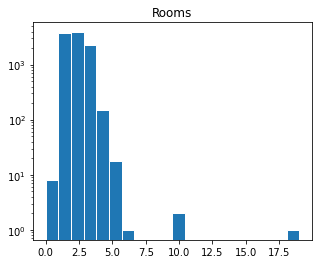

In [30]:
get_hist(data_train, ['Rooms'])

Посчитаем медианы по признаку *Square* для квартир с разным количеством комнат, затем для каждой записи с некорректным значением признака *Rooms* посчитаем разность между каждой медианой и признаком *Square*. По минимальной разности будем присваивать то или иное значение признаку *Rooms*.

In [31]:
median_square_dict = {}

def set_rooms(df, target=target):
    for col in added_cols:
        if target in df.columns:
            square_medians = df.loc[
                (df['Rooms'] > 0) & (df['Rooms'] < 6) & (df[col] == 1),
                ['Rooms', 'Square']
            ].groupby(by='Rooms').median()
            median_square_dict[col] = square_medians

        rooms_condition = ((df['Rooms'] == 0) | (df['Rooms'] > 5)) & (df[col] == 1)
        cur_df = df.loc[rooms_condition, 'Square']
        if len(cur_df) > 0:
            for i in cur_df.index:
                df.loc[i, 'Rooms'] = np.abs(median_square_dict[col] - cur_df.loc[i]).idxmin()['Square']
    df['Rooms'] = df['Rooms'].astype(np.uint8)

In [32]:
set_rooms(data_train)
set_rooms(data_test)

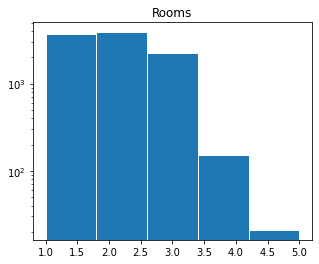

In [33]:
get_hist(data_train, ['Rooms'], bins=5)

**Обработка признаков *Square*, *LifeSquare* и *KitchenSquare*.**

In [34]:
data_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,1.000000e+04,7887.000000,1.000000e+04
mean,inf,inf,6.273438e+00
std,inf,inf,inf
min,1.136719e+00,0.370605,0.000000e+00
25%,4.178125e+01,22.765625,1.000000e+00
50%,5.250000e+01,32.781250,6.000000e+00
75%,6.587500e+01,45.125000,9.000000e+00
max,6.410000e+02,7480.000000,2.014000e+03


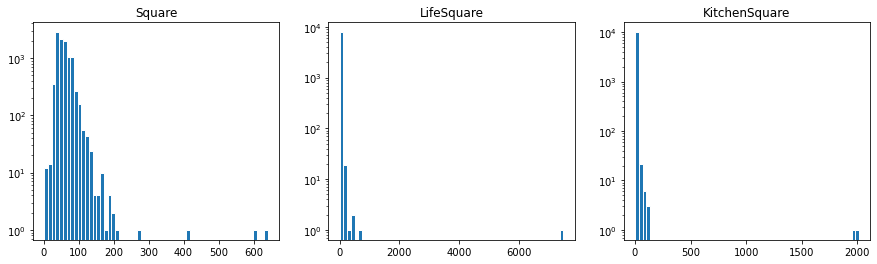

In [35]:
get_hist(data_train, ['Square', 'LifeSquare', 'KitchenSquare'], bins=60)

При построении гистограмм обнаруживаем незначительное количество выбросов. Для признаков находим 0,025- и 0,975-квантили в зависимости от принадлежности к временному интервалу и количества комнат, затем находим значения меньше 0,025-квантиля и присваиваем им новое значение, равное 0,025-квантилю. Аналогичные преобразования производим со значениями, которые выше 0,975-квантиля.

In [85]:
quantile_dict = {}

def set_num_feature_by_quantile(
    df, feature, q_min, q_max, added_cols=None, group_feature=None, target=target
    ):
    '''Set the values of numerical feature by quantiles'''

    feature_type = str(df[feature].dtype)
    if 'int' in feature_type or 'float' in feature_type:
        if added_cols is not None:
            for col in added_cols:
                if group_feature is not None:
                    if target in df.columns:
                        feature_quantile_min = df.loc[df[col] == 1, [group_feature, feature]]\
                            .groupby(by=group_feature).quantile(q_min)
                        feature_quantile_max = df.loc[df[col] == 1, [group_feature, feature]]\
                            .groupby(by=group_feature).quantile(q_max)
                        quantile_dict[f'{feature}_c-{col}_g-{group_feature}'] = (
                            feature_quantile_min, feature_quantile_max
                            )

                    for i in [int(elem) for elem in (quantile_dict[f'{feature}_c-{col}_g-{group_feature}'][0].index)]:
                        min_condition = (df[col] == 1) & (df[group_feature] == i) & \
                            (df[feature] < quantile_dict[f'{feature}_c-{col}_g-{group_feature}'][0].loc[i, feature])
                        max_condition = (df[col] == 1) & (df[group_feature] == i) & \
                            (df[feature] > quantile_dict[f'{feature}_c-{col}_g-{group_feature}'][1].loc[i, feature])
                        df.loc[min_condition, feature] = quantile_dict[f'{feature}_c-{col}_g-{group_feature}'][0]\
                            .loc[i, feature]
                        df.loc[max_condition, feature] = quantile_dict[f'{feature}_c-{col}_g-{group_feature}'][1]\
                            .loc[i, feature]

                else:
                    if target in df.columns:
                        feature_quantile_min = df.loc[df[col] == 1, [feature]].quantile(q_min)
                        feature_quantile_max = df.loc[df[col] == 1, [feature]].quantile(q_max)
                        quantile_dict[f'{feature}_c-{col}'] = (feature_quantile_min, feature_quantile_max)
        
                    min_condition = (df[col] == 1) & (df[feature] < quantile_dict[f'{feature}_c-{col}'][0][feature])
                    max_condition = (df[col] == 1) & (df[feature] > quantile_dict[f'{feature}_c-{col}'][1][feature])
                    df.loc[min_condition, feature] = quantile_dict[f'{feature}_c-{col}'][0][feature]
                    df.loc[max_condition, feature] = quantile_dict[f'{feature}_c-{col}'][1][feature]

        else:
            if group_feature is not None:
                if target in df.columns:
                    feature_quantile_min = df.loc[:, [group_feature, feature]].groupby(by=group_feature)\
                        .quantile(q_min)
                    feature_quantile_max = df.loc[:, [group_feature, feature]].groupby(by=group_feature)\
                        .quantile(q_max)
                    quantile_dict[f'{feature}_g-{group_feature}'] = (feature_quantile_min, feature_quantile_max)

                for i in [int(elem) for elem in (quantile_dict[f'{feature}_g-{group_feature}'][0].index)]:
                    min_condition = (df[group_feature] == i) \
                        & (df[feature] < quantile_dict[f'{feature}_g-{group_feature}'][0].loc[i, feature])
                    max_condition = (df[group_feature] == i) \
                        & (df[feature] > quantile_dict[f'{feature}_g-{group_feature}'][1].loc[i, feature])
                    df.loc[min_condition, feature] = quantile_dict[f'{feature}_g-{group_feature}'][0]\
                        .loc[i, feature]
                    df.loc[max_condition, feature] = quantile_dict[f'{feature}_g-{group_feature}'][1]\
                        .loc[i, feature]

            else:
                if target in df.columns:
                    feature_quantile_min = df.loc[:, [feature]].quantile(q_min)
                    feature_quantile_max = df.loc[:, [feature]].quantile(q_max)
                    quantile_dict[f'{feature}'] = (feature_quantile_min, feature_quantile_max)
        
                min_condition = df[feature] < quantile_dict[f'{feature}'][0][feature]
                max_condition = df[feature] > quantile_dict[f'{feature}'][1][feature]
                df.loc[min_condition, feature] = quantile_dict[f'{feature}'][0][feature]
                df.loc[max_condition, feature] = quantile_dict[f'{feature}'][1][feature]
        
    else:
        print('Признак должен описываться в числовом формате!')

In [37]:
for f in ('Square', 'LifeSquare', 'KitchenSquare'):
    set_num_feature_by_quantile(data_train, f, .025, .975, added_cols=added_cols, group_feature='Rooms')
    set_num_feature_by_quantile(data_test, f, .025, .975, added_cols=added_cols, group_feature='Rooms')

По признаку *KitchenSquare* наблюдается большое количество записей со значениями менее 5. Сгруппируем по признаку *HouseYear* такие записи и посчитаем их количество для каждого года.

In [38]:
low_kitchen = data_train.loc[
    data_train['KitchenSquare'] < 5, ['KitchenSquare', 'HouseYear']
    ].groupby('HouseYear').count()
low_kitchen.sort_values(by='KitchenSquare', ascending=False).head(10)

,KitchenSquare
HouseYear,
1977,2272
2017,198
2016,198
2015,185
2014,113
2018,99
2019,35
2013,21
1966,7


Как видим, большее количество таких записей приходится на 1977 год. Так как в новых домах могут быть квартиры-студии, то такие записи обрабатывать не будем. Обработаем только записи, где значение признака *HouseYear* менее 2000 и значение признака *Rooms* более 1 (исключаем возможные квартиры гостинного типа - КГТ). Заменим значения признака *KitchenSquare* в таких записях на медиану данного признака.

In [39]:
median_dict = {}

def set_num_feature_by_median(
    df, feature, condition, added_cols=None, group_feature=None, target=target
    ):
    '''Set the values of numerical feature by medians'''

    feature_type = str(df[feature].dtype)
    if 'int' in feature_type or 'float' in feature_type:
        if added_cols is not None:
            for col in added_cols:
                if group_feature is not None:
                    if target in df.columns:
                        feature_medians = df.loc[
                                                df[col] == 1, [group_feature, feature]
                                                ].groupby(by=group_feature).median()
                        median_dict[f'{feature}_c-{col}_g-{group_feature}'] = feature_medians
                        
                    for i in [int(elem) for elem in (median_dict[f'{feature}_c-{col}_g-{group_feature}'].index)]:
                        current_condition = condition & (df[group_feature] == i) & (df[col] == 1)
                        df.loc[current_condition, feature] = median_dict[f'{feature}_c-{col}_g-{group_feature}']\
                            .loc[i, feature]

                else:
                    if target in df.columns:
                        feature_medians = df.loc[df[col] == 1, feature].median()
                        median_dict[f'{feature}_c-{col}'] = feature_medians
                        
                    current_condition = condition & (df[col] == 1)
                    df.loc[current_condition, feature] = median_dict[f'{feature}_c-{col}']

        else:
            if group_feature is not None:
                if target in df.columns:
                    feature_medians = df.loc[:, [group_feature, feature]].groupby(by=group_feature).median()
                    median_dict[f'{feature}_g-{group_feature}'] = feature_medians
                    
                for i in [int(elem) for elem in (median_dict[f'{feature}_g-{group_feature}'].index)]:
                    current_condition = condition & (df[group_feature] == i)
                    df.loc[current_condition, feature] = median_dict[f'{feature}_g-{group_feature}'].loc[i, feature]

            else:
                if target in df.columns:
                    feature_medians = df[feature].median()
                    median_dict[f'{feature}'] = feature_medians
                    
                current_condition = condition
                df.loc[current_condition, feature] = median_dict[f'{feature}']
        
    else:
        print('Признак должен описываться в числовом формате!')

In [40]:
for df in [data_train, data_test]:
    kitchensquare_condition = (df['KitchenSquare'] < 5) & (df['Rooms'] > 1) & (df['HouseYear'] < 2000)
    set_num_feature_by_median(
        df, 'KitchenSquare', kitchensquare_condition, added_cols=added_cols, group_feature='Rooms'
        )

In [41]:
print(
    "Количество записей в тренировочном наборе, где жилая площадь больше общей площади, равно",
    f"{len(data_train.loc[(data_train['LifeSquare'] > data_train['Square']), 'Id'])}."
    )
print(
    "Количество записей в тестовом наборе, где жилая площадь больше общей площади, равно",
    f"{len(data_test.loc[(data_test['LifeSquare'] > data_test['Square']), 'Id'])}."
    )

Количество записей в тренировочном наборе, где жилая площадь больше общей площади, равно 408.
Количество записей в тестовом наборе, где жилая площадь больше общей площади, равно 201.


В тех записях, где жилая площадь больше общей площади, либо значение жилой площади пропущено, присвоим значению признака *LifeSquare* значение разности признака *Square* и удвоенного признака *KitchenSquare*.

In [42]:
for df in [data_train, data_test]:
    df.loc[(df['LifeSquare'] > df['Square']) | (df['LifeSquare'].isna()), 'LifeSquare'] = df['Square'] \
        - 2*df['KitchenSquare']

In [43]:
data_train[['Square', 'LifeSquare', 'KitchenSquare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         10000 non-null  float16
 1   LifeSquare     10000 non-null  float16
 2   KitchenSquare  10000 non-null  float16
dtypes: float16(3)
memory usage: 58.7 KB


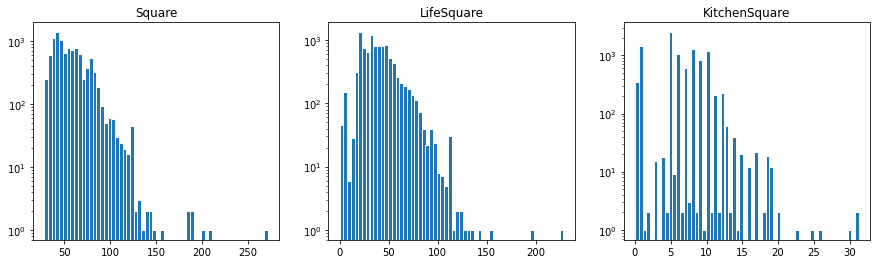

In [44]:
get_hist(data_train, ['Square', 'LifeSquare', 'KitchenSquare'], bins=60)

**Обработка признака *Ecology_1*.**

In [45]:
data_train['Ecology_1'].describe()

count    10000.000000
mean         0.118896
std          0.119019
min          0.000000
25%          0.017654
50%          0.075439
75%          0.195801
max          0.521973
Name: Ecology_1, dtype: float64

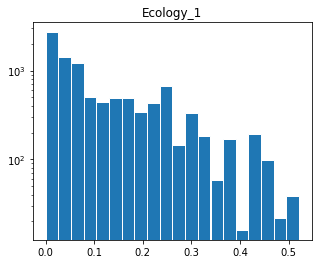

In [46]:
get_hist(data_train, ['Ecology_1'])

Данный признак пропусков и выбросов не имеет, в обработке не нуждается.

**Обработка признаков *Social_1*, *Social_2* и *Social_3*.**

In [47]:
data_train[['Social_1', 'Social_2', 'Social_3']].describe()

,Social_1,Social_2,Social_3
count,10000.000000,10000.000000,10000.000000
mean,24.687000,5352.157400,8.039200
std,17.532614,4006.799803,23.831875
min,0.000000,168.000000,0.000000
25%,6.000000,1564.000000,0.000000
50%,25.000000,5285.000000,2.000000
75%,36.000000,7227.000000,5.000000
max,74.000000,19083.000000,141.000000


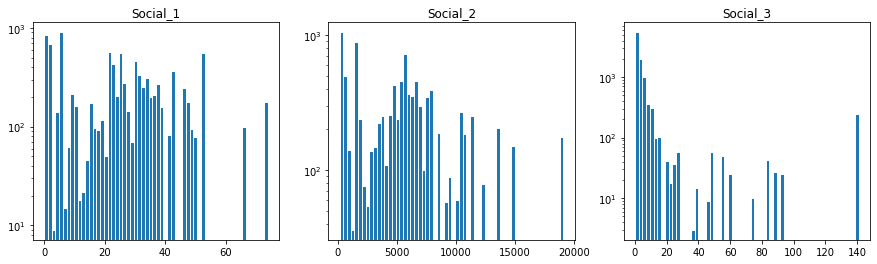

In [48]:
get_hist(data_train, ['Social_1', 'Social_2', 'Social_3'], bins=60)

По гистограммам видно, что имеется некоторое количество выбросов по признаку *Social_3*. Сгруппируем записи по признаку *Social_3* и посчитаем для каждого значения количество записей.

In [49]:
data_train['Social_3'].value_counts().head(15)

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
Name: Social_3, dtype: int64

In [50]:
data_train.loc[data_train['Social_3'] == 141, ['Social_1', 'Social_2', 'Social_3']].head()

,Social_1,Social_2,Social_3
106,22,6398,141
109,22,6398,141
288,22,6398,141
293,22,6398,141
330,22,6398,141


Посмотрим внимательнее на записи со значениями признаков *Social_1* равным 22, *Social_2* равным 6398 и *Social_3* равным 141.

In [51]:
data_train.loc[
               (data_train['Social_3'] == 141) & (data_train['Social_2'] == 6398) & (data_train['Social_1'] == 22), 
               ['DistrictId', 'Social_3']
               ].groupby(by='DistrictId').count()

,Social_3
DistrictId,
4,2
30,228
43,5
104,4
174,1
189,5


Наблюдаем ряд квартир в одних и тех же районах (4, 30, 43, 104, 174, 189) с неизменными признаками *Social_1*, *Social_2*, *Social_3*. Так как значения признаков *Social_1* и *Social_2* по величине не походят на выбросы, обработаем только выбросы значения признака *Social_3*, заменив их медианой.

In [52]:
social_3_median = int(data_train['Social_3'].median())
for df in [data_train, data_test]:
    df.loc[df['Social_3'] == 141, ['Social_3']] = social_3_median

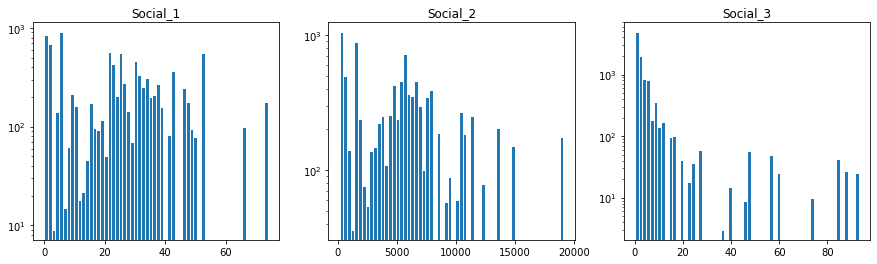

In [53]:
get_hist(data_train, ['Social_1', 'Social_2', 'Social_3'], bins=60)

**Обработка признаков *Healthcare_1*, *Helthcare_2* и *Shops_1*.**

In [54]:
data_train[['Healthcare_1', 'Helthcare_2', 'Shops_1']].describe()

,Healthcare_1,Helthcare_2,Shops_1
count,5202.0,10000.000000,10000.000000
mean,inf,1.319500,4.231300
std,inf,1.493601,4.806341
min,0.0,0.000000,0.000000
25%,350.0,0.000000,1.000000
50%,900.0,1.000000,3.000000
75%,1548.0,2.000000,6.000000
max,4848.0,6.000000,23.000000


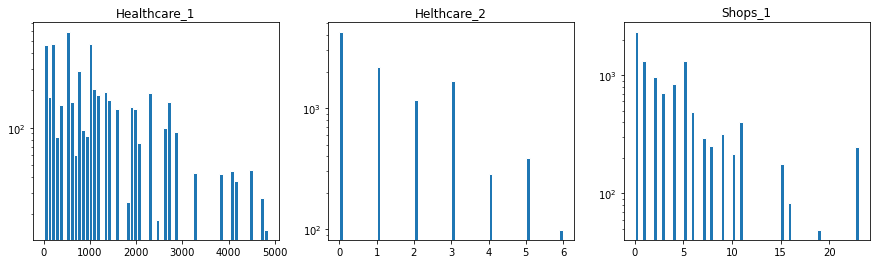

In [55]:
get_hist(data_train, ['Healthcare_1', 'Helthcare_2', 'Shops_1'], bins=60)

По признакам *Healthcare_1* и *Helthcare_2* выбросы не наблюдаются, а по признаку *Shops_1* видим подозрительно большое количество квартир с максимальным значением для признака равным 23. Посмотрим детальнее на такие записи.

In [56]:
data_train.loc[data_train['Shops_1'] == 23, ['DistrictId', 'Shops_1']].groupby(by='DistrictId').count()

,Shops_1
DistrictId,
4,2
30,228
43,5
104,4
174,1
189,5


Обнаруживаем, что по количеству записей и номерам районов (4, 30, 43, 104, 174, 189) выбросы признака *Shops_1* совпадают с выбросами признака *Social_3*. Обработаем выбросы признака *Shops_1* аналогично - заменив их медианой.

In [57]:
shops_1_median = int(data_train['Shops_1'].median())
for df in [data_train, data_test]:
    df.loc[df['Shops_1'] == 23, ['Shops_1']] = social_3_median

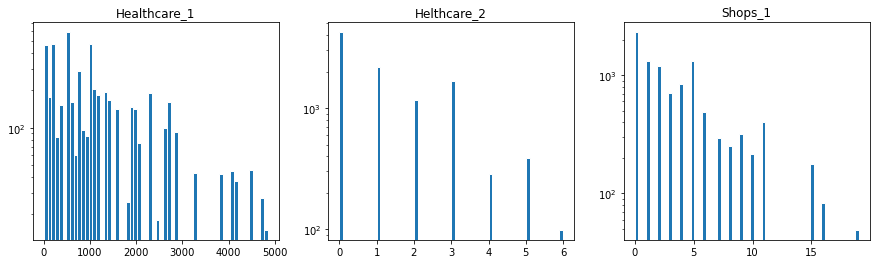

In [58]:
get_hist(data_train, ['Healthcare_1', 'Helthcare_2', 'Shops_1'], bins=60)

In [59]:
print(
    "Количество пропущенных значений признака Healthcare_1 в тренировочном наборе равно",
    f"{len(data_train[data_train['Healthcare_1'].isna()])}."
    )
print(
    "Количество пропущенных значений признака Healthcare_1 в тестовом наборе равно",
    f"{len(data_test[data_test['Healthcare_1'].isna()])}."
    )

Количество пропущенных значений признака Healthcare_1 в тренировочном наборе равно 4798.
Количество пропущенных значений признака Healthcare_1 в тестовом наборе равно 2377.


Данные по признаку *Healthcare_1* имеют пропущенные значения. Заполним их медианными значениями данного признака, согласно номеру района.

In [60]:
for df in [data_train, data_test]:
    healthcare_1_condition = df['Healthcare_1'].isna()
    set_num_feature_by_median(df, 'Healthcare_1', healthcare_1_condition, group_feature='DistrictId')
    # так как по некоторым районам значений признака не было совсем,
    # отсутствующие значения заменяем медианой по признаку в целом
    set_num_feature_by_median(df, 'Healthcare_1', healthcare_1_condition)

In [61]:
print(
    "Количество пропущенных значений признака Healthcare_1 в тренировочном наборе равно",
    f"{len(data_train[data_train['Healthcare_1'].isna()])}."
    )
print(
    "Количество пропущенных значений признака Healthcare_1 в тестовом наборе равно",
    f"{len(data_test[data_test['Healthcare_1'].isna()])}."
    )

Количество пропущенных значений признака Healthcare_1 в тренировочном наборе равно 0.
Количество пропущенных значений признака Healthcare_1 в тестовом наборе равно 0.


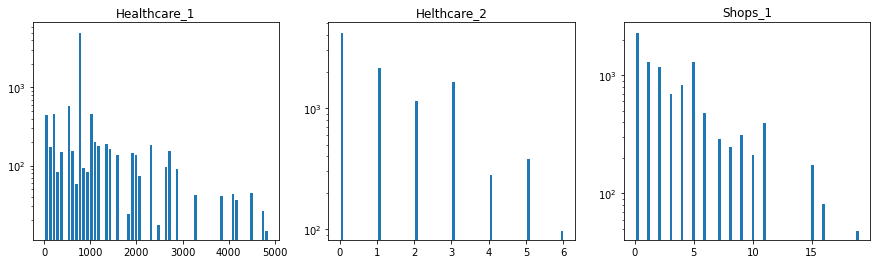

In [62]:
get_hist(data_train, ['Healthcare_1', 'Helthcare_2', 'Shops_1'], bins=60)

**Обработка признаков *Ecology_2*, *Ecology_3* и *Shops_2*.**

In [63]:
data_train[['Ecology_2', 'Ecology_3', 'Shops_2']].describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


Каждый из трех признаков содержит всего 2 уникальных значения - ***A*** и ***B***, при чем значение ***В*** во всех признаках превалирует. Сделаем замену: ***B*** заменим на нуль, ***A*** - на единицу.

In [64]:
for df in [data_train, data_test]:
    for f in ['Ecology_2', 'Ecology_3', 'Shops_2']:
        df.replace({f: {'A': 1, 'B': 0}}, inplace=True)
        df[f] = df[f].astype(np.uint8)

In [65]:
data_train[['Ecology_2', 'Ecology_3', 'Shops_2']].describe()

,Ecology_2,Ecology_3,Shops_2
count,10000.000000,10000.000000,10000.000000
mean,0.009700,0.027500,0.082500
std,0.098015,0.163543,0.275139
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


**Целевая переменная *Price*.**

In [66]:
data_train['Price'].describe()

count     10000.000000
mean     214138.937500
std       92872.273438
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

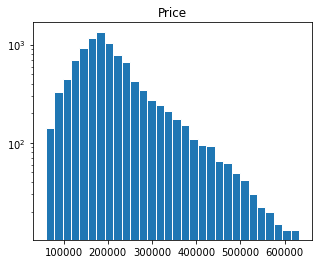

In [67]:
get_hist(data_train, ['Price'], bins=30)

Как видим, выбросов целевая переменная не имеет - какой-либо обработки не требует.

## **3. Создание новых признаков.**

Признак *DistrictId* описывается в числовом формате, по факту же является категориальным. Создадим на его основе новый признак *DistrictWeight*, который будет отражать долю квартир из этого района в тренировочном наборе.

In [68]:
dw = data_train[['Id', 'DistrictId']].groupby(by='DistrictId').count() / data_train.shape[0]
dw.head(10)


,Id
DistrictId,
0,0.0048
1,0.0652
2,0.0078
3,0.0082
4,0.0011
5,0.0034
6,0.0511
7,0.0092
8,0.0142


In [69]:
for df in [data_train, data_test]:
    df['DistrictWeight'] = 0
    for i in dw.index:
        df.loc[df['DistrictId'] == i, 'DistrictWeight'] = dw.loc[i, 'Id']
    df['DistrictWeight'] = df['DistrictWeight'].astype(np.float16)

Используем целевую переменную *Price* для создания нового признака. Исходя из принадлежности к району, рассчитаем среднюю стоимость квадратного метра жилья для квартир с разным количеством комнат.

In [70]:
mean_price_per_meter = data_train.groupby(['DistrictId', 'Rooms'], as_index=False)\
    .agg({'Price':'sum', 'Square': 'sum'})\
    .rename(columns={'Price':'SumPriceByDistrict', 'Square':'SumSquareByDistrict'})

mean_price_per_meter['PricePerMeter'] = mean_price_per_meter['SumPriceByDistrict'] /\
    mean_price_per_meter['SumSquareByDistrict']

mean_price_per_meter.drop(['SumPriceByDistrict', 'SumSquareByDistrict'], axis=1, inplace=True)
mean_price_per_meter.head(11)

,DistrictId,Rooms,PricePerMeter
0,0,1,3539.993652
1,0,2,3520.887451
2,0,3,3769.151367
3,1,1,3373.685059
4,1,2,3165.623779
5,1,3,2978.236328
6,1,4,2776.377686
7,2,1,4716.640137
8,2,2,4490.625977
9,2,3,4516.192871


Как и предполагалось, самый дорогой квадратный метр в большинстве случаев у однокомнатных квартир.

In [71]:
data_train = data_train.merge(mean_price_per_meter, on=['DistrictId', 'Rooms'], how='left')
data_train[['DistrictId', 'Rooms', 'PricePerMeter']].head(10)

,DistrictId,Rooms,PricePerMeter
0,27,3,2690.788818
1,22,1,4008.222656
2,1,3,2978.236328
3,1,1,3373.685059
4,94,2,4146.534668
5,99,3,3617.914795
6,44,1,4831.736816
7,59,2,4998.172852
8,1,1,3373.685059
9,6,3,2670.641846


In [72]:
data_test = data_test.merge(mean_price_per_meter, on=['DistrictId', 'Rooms'], how='left')
data_test[['DistrictId', 'Rooms', 'PricePerMeter']].head(10)

,DistrictId,Rooms,PricePerMeter
0,44,1,4831.736816
1,62,1,2904.845947
2,27,2,2619.072510
3,23,3,2135.302002
4,74,1,3413.357178
5,38,3,4217.625977
6,62,1,2904.845947
7,2,2,4490.625977
8,1,1,3373.685059
9,62,2,2694.001709


In [73]:
data_test['PricePerMeter'].describe()

count    4935.000000
mean     3897.828857
std       993.299072
min      1070.798950
25%      3092.023438
50%      3999.341553
75%      4543.317383
max      8804.844727
Name: PricePerMeter, dtype: float64

Как видим, в тестовом наборе данных заполнены не все значения признака *PricePerMeter*. Применим функцию *set_num_feature_by_median* для заполнения данными пропущенных значений.

In [74]:
for df in [data_train, data_test]:
    condition = df['PricePerMeter'].isna()
    set_num_feature_by_median(df, 'PricePerMeter', condition, group_feature='Rooms', target=target)

Посмотрим на корреляцию признаков с целевой переменной.

In [75]:
corr = data_train.corr()
high_corr = corr[(np.abs(corr[target]) > 0.25) & (corr.index != target)][target]
print(
    f'Список признаков, корреляция которых с целевой переменной {target} по абсолютному значению превышает 0.25:',
    *high_corr.index, sep='\n-> '
    )

Список признаков, корреляция которых с целевой переменной Price по абсолютному значению превышает 0.25:
-> DistrictId
-> Rooms
-> Square
-> LifeSquare
-> KitchenSquare
-> Social_1
-> Social_3
-> Helthcare_2
-> Shops_1
-> DistrictWeight
-> PricePerMeter


Ожидаемо видим, что стоимость квартир зависит в большей степени от характеристик самой квартиры и показателей, указывающих наличие инфраструктуры, а также то, что новые признаки очень хорошо коррелируют с целевой переменной, ведь одна из них рассчитана на ее основании.

## **4. Построение предсказательной модели.**

Для оценки предсказательной модели будем использовать функцию *evaluate_preds*.

In [76]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Outputs R2-score and plots to evaluate the quality of the model.
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [77]:
y = data_train[target]
X = data_train.drop(['Id', 'DistrictId', 'Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=42
    )

In [78]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train R2:	0.809
Test R2:	0.77


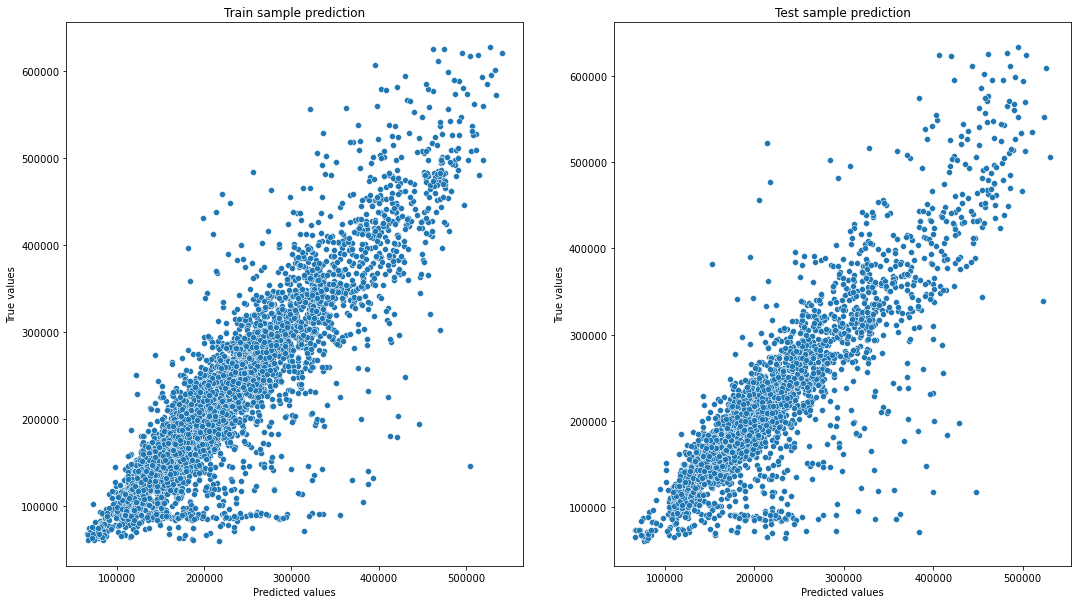

In [79]:
gb_model = GradientBoostingRegressor(
    n_estimators=130, learning_rate=0.07, max_depth=4, random_state=42, loss='ls', min_samples_split=250,
     min_samples_leaf=50
    )
gb_model.fit(X_train_scaled, y_train)
y_train_preds = gb_model.predict(X_train_scaled)
y_test_preds = gb_model.predict(X_test_scaled)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [83]:
cv_score = cross_val_score(
    gb_model,
    X, y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

In [84]:
cv_score.mean()

0.7731951115453312

## **5. Предсказание на тестовом наборе данных и сохранение результата.**

In [82]:
test_df = data_test.drop(['Id', 'DistrictId'], axis=1)
test_df_scaled = scaler.transform(test_df)

y_test_df_scaled_preds = gb_model.predict(test_df_scaled)

pred_df = pd.read_csv('sample_submission.csv')
pred_df['Price'] = y_test_df_scaled_preds
pred_df.to_csv("RMirskov_predictions.csv", index=False)